In [2]:
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

from discopy.tensor import Tensor
from jax import numpy as np
import numpy

np.random = numpy.random
Tensor.np = np

np.random.seed(123458)  # Fix the seed

In [7]:
import os
os

<module 'os' from '/home/poig/miniconda3/envs/womanium/lib/python3.10/os.py'>

In [11]:
# Read data
def read_data(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    data, targets = [], []
    for ln in lines:
        t = int(ln[0])
        data.append(ln[1:].strip())
        targets.append(np.array([t, not(t)], dtype=np.float32))
    return data, np.array(targets)

train_data, train_targets = read_data('examples/datasets/mc_train_data.txt')
test_data, test_targets = read_data('examples/datasets/mc_test_data.txt')

In [12]:
train_data[:10]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .',
 'woman prepares tasty meal .',
 'person runs program .',
 'person runs useful application .',
 'woman prepares sauce .',
 'woman prepares dinner .']

In [13]:
train_targets

DeviceArray([[1., 0.],
             [1., 0.],
             [1., 0.],
             ...,
             [0., 1.],
             [1., 0.],
             [0., 1.]], dtype=float32)

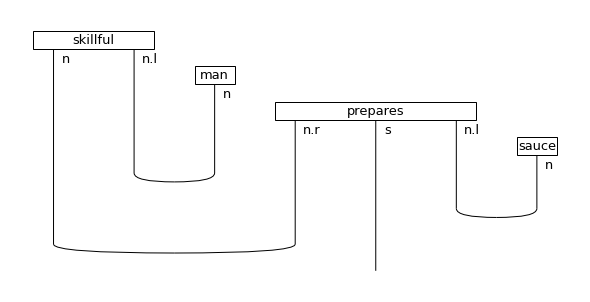

In [14]:
# Parse sentences to diagrams

from lambeq import BobcatParser

parser = BobcatParser(verbose='suppress')
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

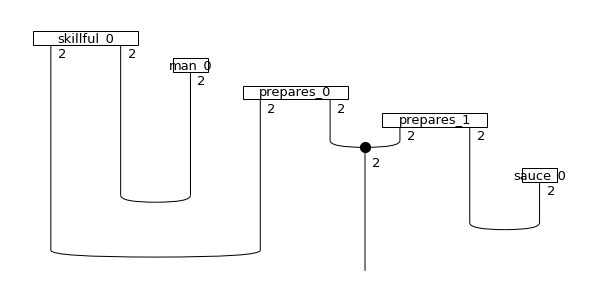

In [15]:
# Create ansatz and convert to tensor diagrams

from lambeq import AtomicType, SpiderAnsatz
from discopy import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

In [16]:
# Create vocabulary

from sympy import default_sort_key

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.17825215, 0.02690565])

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

In [18]:
from jax import jit, grad

training_loss = jit(loss)
gradient = jit(grad(loss))

In [19]:
training_losses = []

epochs = 90

for i in range(epochs):

    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

Epoch 10 - loss 0.18159328401088715
Epoch 20 - loss 0.028411220759153366
Epoch 30 - loss 0.014218387193977833
Epoch 40 - loss 0.009306452237069607
Epoch 50 - loss 0.006690497510135174
Epoch 60 - loss 0.0050796098075807095
Epoch 70 - loss 0.004009702242910862
Epoch 80 - loss 0.003261777339503169
Epoch 90 - loss 0.0027179380413144827


In [20]:
# Testing

np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

Accuracy on test set: 0.9


In [1]:
test_targets[1]

NameError: name 'test_targets' is not defined

In [ ]:
test_predictions[1]